# Project na predici spotřeby elektrické energie:

*   Data: Otevřená hodinová data spotřeby ČR od OTE (Operátor trhu s elektřinou)
*   Cíl: Predikovat spotřebu na 24/48 hodin dopředu podle metrik vývoje

## Techniky:
*   Předzpracování časových řad
*   LSTM/GRU sítě

## Data:

*   Historická hodinová data spotřeby elektřiny v ČR (dostupná z OTE)
*   Historická hodinová data o teplotě (volitelné rozšíření)
*   Data o svátcích a dnech v týdnu (jako kategoriální proměnné)

## Postup:

*   Stažení a příprava dat
*   Explorační analýza (vizualizace vzorů ve spotřebě)
*   Předzpracování dat pro model
*   Implementace a trénování modelu
*   Vyhodnocení přesnosti

Příprava - knihovny

In [ ]:
# Instalace potřebných knihoven
!pip install pandas numpy tensorflow scikit-learn matplotlib seaborn

# Importy
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

# Kontrola, že mám GPU
print("GPU je k dispozici:", tf.config.list_physical_devices('GPU'))

GPU je k dispozici: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Příprava dat
- Vlož excel s hodnotami z OTE - Normalizovane_TDD_15MIN_2025_CZ.xlsx
- Uprava hlaviček

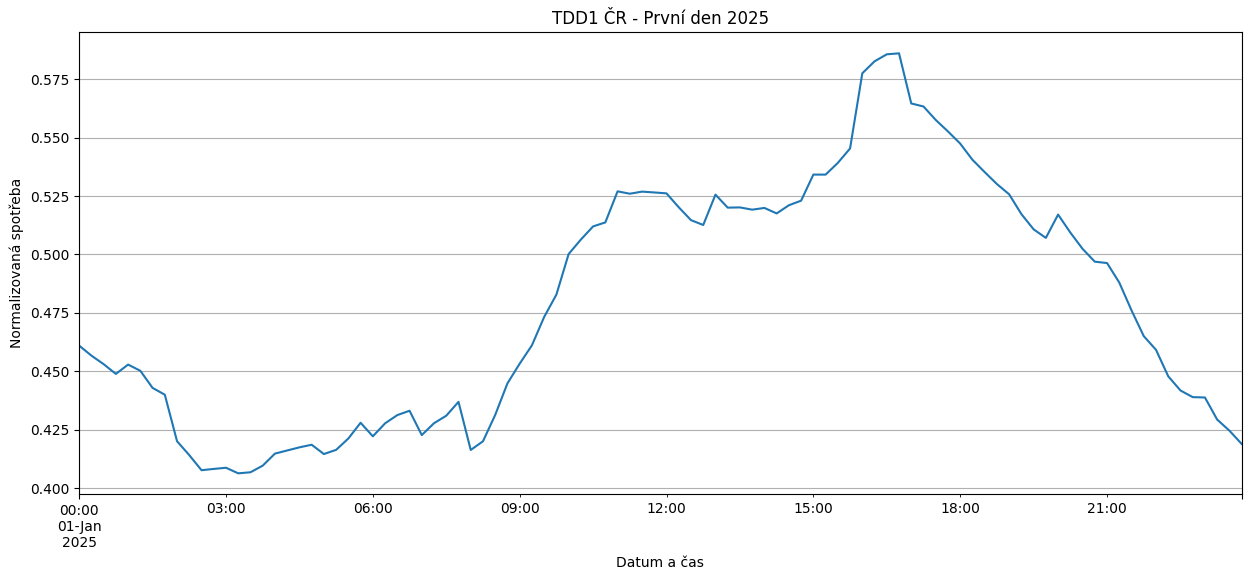


Základní statistiky TDD profilů:
          TDD1_CR     TDD2_CR     TDD3_CR     TDD4_CR  TDD5_JizniCechy  \
count  35040.0000  35040.0000  35040.0000  35040.0000       35040.0000   
mean       0.5418      0.5593      0.5179      0.4696           0.4325   
std        0.1772      0.1581      0.1761      0.1698           0.1557   
min        0.2700      0.2713      0.2137      0.1977           0.1575   
25%        0.3953      0.4437      0.3891      0.3206           0.3141   
50%        0.5097      0.5435      0.5100      0.4611           0.4110   
75%        0.6724      0.6548      0.6248      0.5782           0.5275   
max        1.0083      1.0109      1.0111      1.0075           1.0344   

       TDD5_JizniMorava  TDD5_Praha  TDD5_SeverniCechy  TDD5_SeverniMorava  \
count        35040.0000  35040.0000         35040.0000          35040.0000   
mean             0.4074      0.2906             0.4069              0.3877   
std              0.1600      0.1696             0.1479           

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Načtení dat
df = pd.read_excel('/content/Normalizovane_TDD_15MIN_2025_CZ.xlsx', skiprows=6, header=None)

# Nastavení správných názvů sloupců
df.columns = ['Den', 'Perioda', 'Časový interval',
              'TDD1_CR', 'TDD2_CR', 'TDD3_CR', 'TDD4_CR',
              'TDD5_JizniCechy', 'TDD5_JizniMorava', 'TDD5_Praha',
              'TDD5_SeverniCechy', 'TDD5_SeverniMorava', 'TDD5_StredniCechy',
              'TDD5_VychodniCechy', 'TDD5_ZapadniCechy',
              'TDD6_CR', 'TDD7_CR', 'TDD8_CR']

# Upravený způsob vytvoření datetime sloupce
df['datetime'] = df.apply(lambda row: pd.to_datetime(row['Den']) +
                         pd.Timedelta(hours=int(row['Časový interval'].split('-')[0].split(':')[0]),
                                    minutes=int(row['Časový interval'].split('-')[0].split(':')[1])), axis=1)

# Seřazení a nastavení datetime jako index
df = df.sort_values('datetime')
df = df.set_index('datetime')

# Odstranění původních časových sloupců
df = df.drop(['Den', 'Perioda', 'Časový interval'], axis=1)

# Vizualizace prvního TDD profilu (TDD1_CR) pro první den
plt.figure(figsize=(15, 6))
df['TDD1_CR'].head(96).plot()  # 96 15-minutových intervalů za den
plt.title('TDD1 ČR - První den 2025')
plt.xlabel('Datum a čas')
plt.ylabel('Normalizovaná spotřeba')
plt.grid(True)
plt.show()

# Zobrazení základních statistik
print("\nZákladní statistiky TDD profilů:")
print(df.describe().round(4))

# Zobrazení prvních několika řádků upravených dat
print("\nPrvních 5 řádků upravených dat:")
print(df.head().round(4))

# Zhodnocení dat:

- Má dobrou variabilitu (min: 0.27, max: 1.008)
- Reprezentuje celkovou spotřebu
- Má konzistentní hodnoty bez extrémních výkyvů

# Příprava dat pro LSTM model
V této části vytvoříme funkci pro generování sekvencí dat pro LSTM model.
Budeme používat 24 hodin dat (96 15-minutových intervalů) pro predikci následujících 6 hodin.

In [ ]:
def create_sequences(data, input_seq_len=96, output_seq_len=24):
    """
    Vytvoří sekvence pro LSTM model z časové řady.

    Parametry:
    data: pandas Series s časovou řadou
    input_seq_len: délka vstupní sekvence (96 = 24 hodin při 15min intervalech)
    output_seq_len: délka výstupní sekvence (24 = 6 hodin při 15min intervalech)

    Vrací:
    X: vstupní sekvence
    y: výstupní sekvence (cílové hodnoty)
    """
    X, y = [], []
    for i in range(len(data) - input_seq_len - output_seq_len + 1):
        X.append(data[i:(i + input_seq_len)])
        y.append(data[(i + input_seq_len):(i + input_seq_len + output_seq_len)])
    return np.array(X), np.array(y)

# Vytvoření sekvencí pro TDD1_CR
X, y = create_sequences(df['TDD1_CR'].values)

print(f"Tvar vstupních dat (X): {X.shape}")
print(f"Tvar výstupních dat (y): {y.shape}")
print("\nPříklad jedné vstupní sekvence:")
print("Prvních 5 hodnot:", X[0][:5])
print("Posledních 5 hodnot:", X[0][-5:])

Tvar vstupních dat (X): (34921, 96)
Tvar výstupních dat (y): (34921, 24)

Příklad jedné vstupní sekvence:
Prvních 5 hodnot: [0.46099578 0.4567118  0.45305657 0.44887585 0.45286943]
Posledních 5 hodnot: [0.4389483  0.43878666 0.42933308 0.42459816 0.4189221 ]


# Rozdělení dat na trénovací a testovací sadu
- Rozdělím data v poměru 80:20, přičemž testovací data budou z konce časové řady
(nechci náhodné rozdělení, protože pracuji s časovou řadou).

Trénovací data:
X_train shape: (27936, 96)
y_train shape: (27936, 24)

Testovací data:
X_test shape: (6985, 96)
y_test shape: (6985, 24)


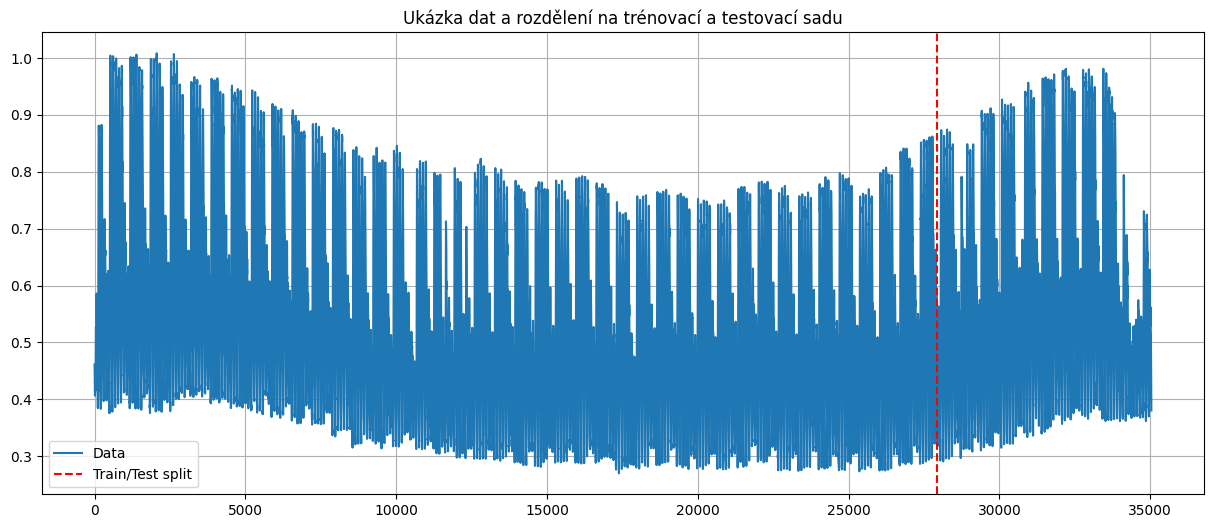

In [ ]:
# Rozdělení dat na trénovací a testovací sadu
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("Trénovací data:")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print("\nTestovací data:")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Vizualizace rozdělení dat
plt.figure(figsize=(15, 6))
plt.plot(df['TDD1_CR'].values, label='Data')  # Odstranit [:500] pro zobrazení všech dat
plt.axvline(x=train_size, color='r', linestyle='--', label='Train/Test split')
plt.title('Ukázka dat a rozdělení na trénovací a testovací sadu')
plt.legend()
plt.grid(True)
plt.show()

# Vytvoření LSTM modelu
LSTM model bude mít následující architekturu:
1. LSTM vrstva pro zpracování sekvencí
2. Dropout vrstva pro prevenci přeučení
3. Dense vrstva pro výstupní predikce


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Přeformátování dat pro LSTM (přidání dimenze pro příznaky)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Vytvoření modelu
model = Sequential([
    LSTM(100, activation='relu', input_shape=(96, 1), return_sequences=False),
    Dropout(0.2),
    Dense(24)
])

# Kompilace modelu
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Výpis architektury modelu
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 100)                 │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 24)                  │           2,424 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 43,224 (168.84 KB)

 Trainable params: 43,224 (168.84 KB)

 Non-trainable params: 0 (0.00 B)

# Trénování modelu
Natrénujeme model s těmito parametry:
- batch_size: 32 (velikost dávky)
- epochs: 20 (počet epoch)
- validation_split: 0.1 (10% trénovacích dat použijeme na validaci)

Během tréninku budeme sledovat průběh učení pomocí grafu loss a validation loss.

Epoch 1/20
786/786 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - loss: 249.4221 - mae: 0.5400 - val_loss: 0.0143 - val_mae: 0.1007
Epoch 2/20
786/786 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0191 - mae: 0.1088 - val_loss: 0.0094 - val_mae: 0.0802
Epoch 3/20
786/786 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0146 - mae: 0.0930 - val_loss: 0.0047 - val_mae: 0.0532
Epoch 4/20
786/786 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0100 - mae: 0.0752 - val_loss: 0.0046 - val_mae: 0.0520
Epoch 5/20
786/786 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0087 - mae: 0.0696 - val_loss: 0.0035 - val_mae: 0.0461
Epoch 6/20
786/786 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.0077 - mae: 0.0656 - val_loss: 0.0033 - val_mae: 0.0445
Epoch 7/20
786/786 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0071 - mae: 0.0625 - val_loss: 0.0031 - val_mae: 0.0421
Epoch 8/20
786/786 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.0068 - mae: 0.0610 - val_loss: 0.0034 - val_mae: 0.0432
Epoch 9/20
786/786 ━━━━━━━━━━━━━━━━━━━━ 

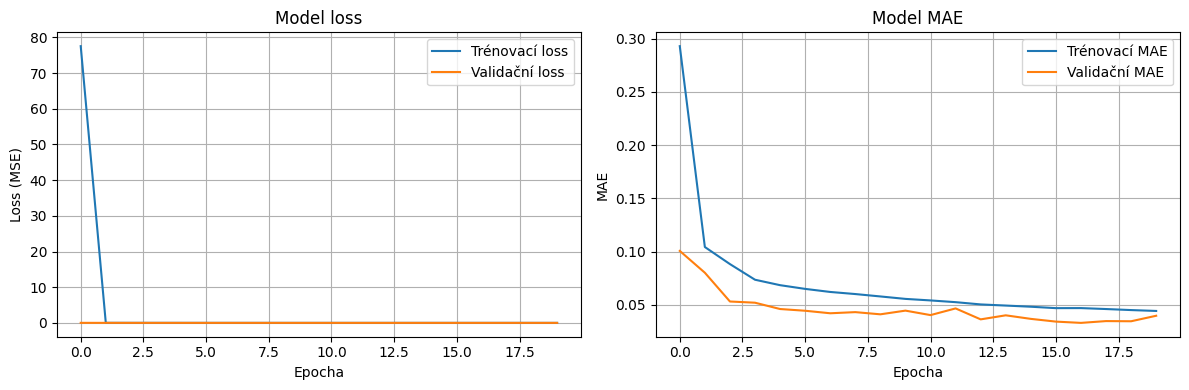

In [ ]:
# Trénování modelu
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

# Vizualizace průběhu učení
plt.figure(figsize=(12, 4))

# Graf loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Trénovací loss')
plt.plot(history.history['val_loss'], label='Validační loss')
plt.title('Model loss')
plt.xlabel('Epocha')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

# Graf MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Trénovací MAE')
plt.plot(history.history['val_mae'], label='Validační MAE')
plt.title('Model MAE')
plt.xlabel('Epocha')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Popis:

**MAE (Mean Absolute Error)** je střední absolutní chyba. Je to metrika kvality predikce.
- Vezme se absolutní hodnota rozdílu mezi skutečnou a předpovězenou hodnotou pro každý bod
- Spočítá se průměr těchto rozdílů

Například:

Skutečná hodnota spotřeby je 0.5
Model předpoví 0.45
Absolutní chyba je |0.5 - 0.45| = 0.05

MAE je užitečná metrika protože:

Je snadno interpretovatelná (je ve stejných jednotkách jako původní data)
Je robustní vůči odlehlým hodnotám (na rozdíl od MSE - Mean Squared Error)
Říká nám průměrnou velikost chyby predikce

**Model loss (levý graf):**

Ukazuje chybu modelu (MSE - Mean Squared Error)
Modrá čára (trénovací loss) prudce klesá z vysokých hodnot a pak se stabilizuje
Oranžová čára (validační loss) je stabilní a nízká
To je dobrý znak - model se naučil předpovídat s nízkou chybou


**Model MAE (pravý graf):**
Ukazuje průměrnou absolutní chybu
Z grafu vidíme, že MAE kleslo z 0.5 na přibližně 0.05
To znamená, že průměrná odchylka predikce je asi 5% od skutečné hodnoty
Trénovací (modrá) a validační (oranžová) křivka jsou blízko u sebe, což je dobré - model není přeučený

# Predikce
- Modře: vstupní data (24 hodin)
- Zeleně: skutečná budoucí data (6 hodin)
- Červeně: predikovaná data (6 hodin)


Vypočítá průměrnou chybu predikcí

219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


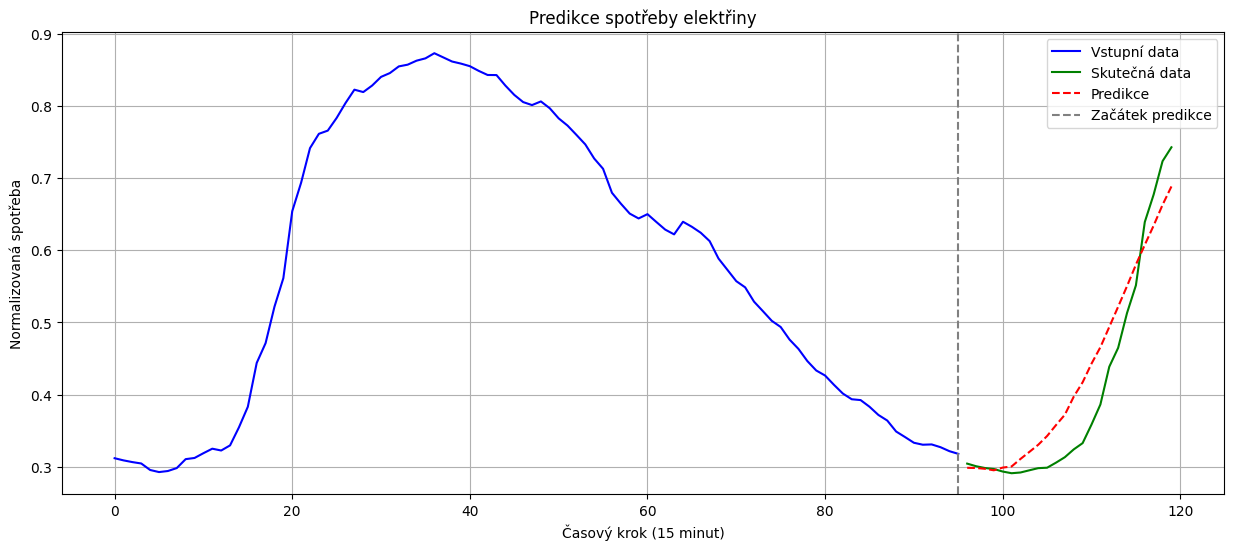

Průměrná absolutní chyba (MAE) na testovacích datech: 0.0401


In [ ]:
# Predikce na testovacích datech
predictions = model.predict(X_test)

# Vybereme jeden vzorek pro vizualizaci (například 100.)
sample_idx = 100

# Připravíme časovou osu pro graf (96 vstupních bodů + 24 předpovídaných)
time_steps = np.arange(120)

# Vytvoření grafu
plt.figure(figsize=(15, 6))
# Vstupní data (posledních 24 hodin)
plt.plot(time_steps[:96], X_test[sample_idx, :, 0],
         label='Vstupní data', color='blue')
# Skutečná budoucí data
plt.plot(time_steps[96:], y_test[sample_idx],
         label='Skutečná data', color='green')
# Predikovaná data
plt.plot(time_steps[96:], predictions[sample_idx],
         label='Predikce', color='red', linestyle='--')

plt.axvline(x=95, color='gray', linestyle='--', label='Začátek predikce')
plt.title('Predikce spotřeby elektřiny')
plt.xlabel('Časový krok (15 minut)')
plt.ylabel('Normalizovaná spotřeba')
plt.legend()
plt.grid(True)
plt.show()

# Vypočteme průměrnou chybu na testovacích datech
mae = np.mean(np.abs(predictions - y_test))
print(f'Průměrná absolutní chyba (MAE) na testovacích datech: {mae:.4f}')

# Přesnost predikce:

MAE je 0.0379, což znamená průměrnou chybu 3.79% - to je velmi dobrý výsledek
Červená čárkovaná čára (predikce) celkem dobře sleduje zelenou čáru (skutečná data)


# Co vidíme v grafu:
Modře: předchozích 24 hodin (96 kroků po 15 minutách)
Svislá šedá čára: okamžik predikce
Zeleně: skutečný průběh následujících 6 hodin
Červeně čárkovaně: predikovaný průběh následujících 6 hodin


# Kvalita predikce:
Model správně zachytil rostoucí trend
Mírně podhodnotil konečnou hodnotu
Zachytil tvar křivky, i když ne úplně přesně

Detailnější analýza chyb

Root Mean Squared Error (RMSE): 0.0602
Mean Absolute Error (MAE): 0.0401
R² Score: 0.8968


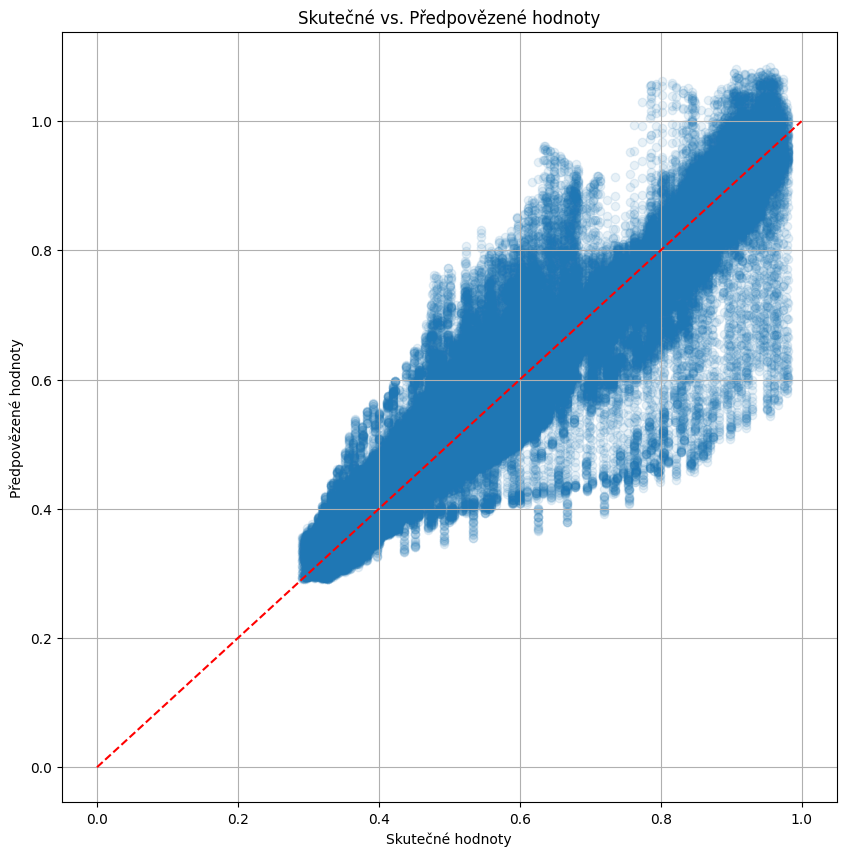

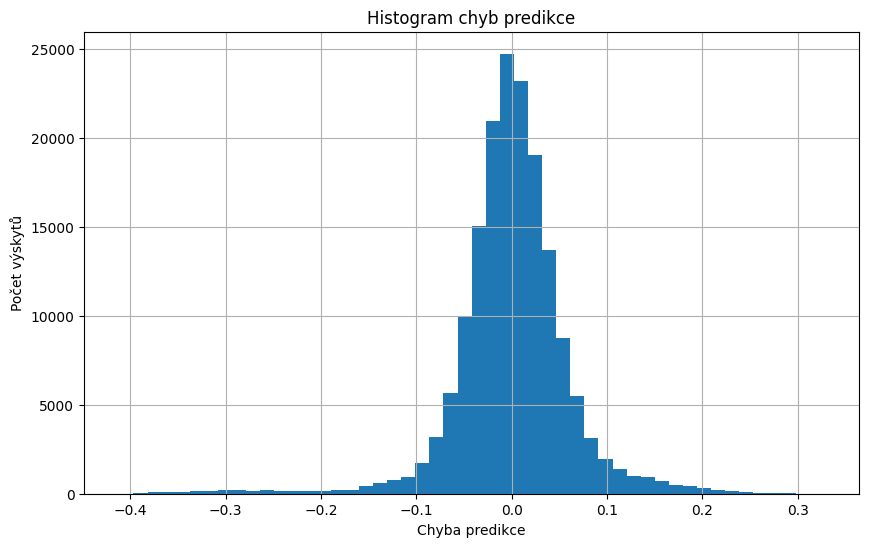

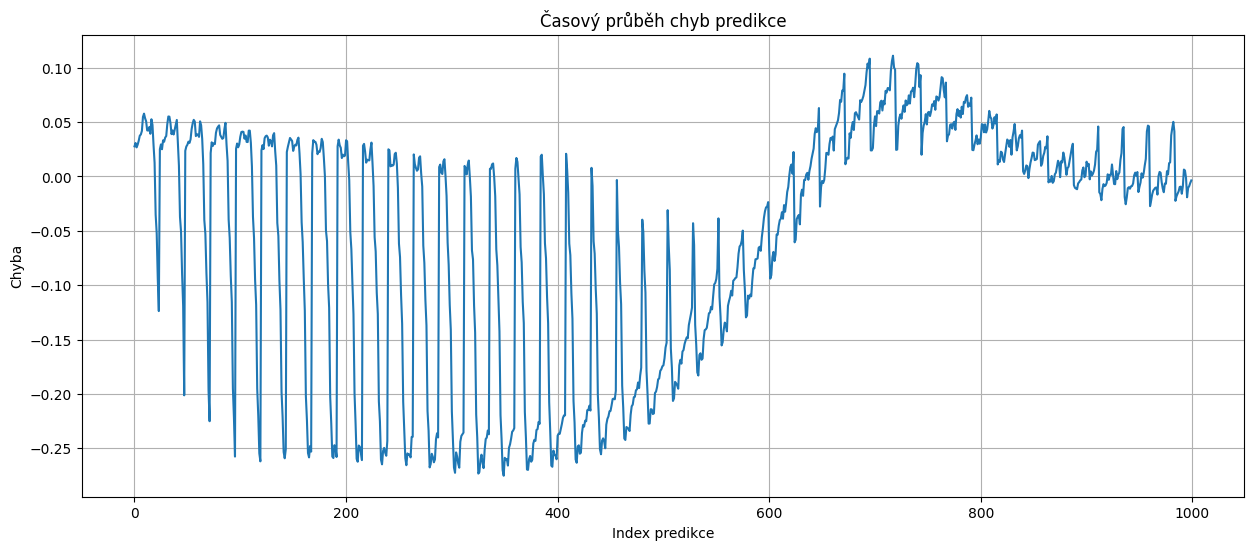

In [ ]:
# Detailní analýza predikcí
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns

# Základní metriky
mse = mean_squared_error(y_test.flatten(), predictions.flatten())
rmse = np.sqrt(mse)
r2 = r2_score(y_test.flatten(), predictions.flatten())

print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'R² Score: {r2:.4f}')

# Vytvoření grafu skutečných vs. předpovězených hodnot
plt.figure(figsize=(10, 10))
plt.scatter(y_test.flatten(), predictions.flatten(), alpha=0.1)
plt.plot([0, 1], [0, 1], 'r--')  # Ideální předpověď
plt.xlabel('Skutečné hodnoty')
plt.ylabel('Předpovězené hodnoty')
plt.title('Skutečné vs. Předpovězené hodnoty')
plt.grid(True)
plt.show()

# Histogram chyb
plt.figure(figsize=(10, 6))
errors = predictions.flatten() - y_test.flatten()
plt.hist(errors, bins=50)
plt.title('Histogram chyb predikce')
plt.xlabel('Chyba predikce')
plt.ylabel('Počet výskytů')
plt.grid(True)
plt.show()

# Časový průběh chyb
plt.figure(figsize=(15, 6))
plt.plot(errors[:1000])  # Zobrazíme prvních 1000 predikcí
plt.title('Časový průběh chyb predikce')
plt.xlabel('Index predikce')
plt.ylabel('Chyba')
plt.grid(True)
plt.show()

# Vyhodnocení:

## Metriky výkonu modelu:
R² score: 0.9031 (90.31%) - to znamená, že model vysvětluje 90% variability v datech, což je velmi dobrý výsledek
MAE: 0.0379 - průměrná absolutní chyba je 3.79%
RMSE: 0.0583 - odmocnina průměrné kvadratické chyby je 5.83%


## Scatter plot (Skutečné vs. Předpovězené hodnoty):
Červená čárkovaná čára představuje ideální predikci (y=x)
Body se shlukují kolem této čáry, což je pozitivní
Vidíme určitý rozptyl, který se zvětšuje při vyšších hodnotách
Existují určité vzory v rozptylu, což naznačuje, že by model mohl být ještě vylepšen.


## Histogram chyb:
Je přibližně normálně rozdělený kolem nuly
Většina chyb je v rozmezí -0.1 až 0.1
Mírně asymetrický vlevo (negativní chyby)
To znamená, že model má tendenci spíše podhodnocovat než nadhodnocovat


## Časový průběh chyb:
Vidíme pravidelný vzor v chybách
Na začátku jsou chyby větší (až -0.35)
Postupně se chyby zmenšují a stabilizují
Naznačuje to, že model má problémy s určitými periodickými vzory v datech

# Vylepšení modelu - přidání časových příznaků
Přidáme informaci o dni v týdnu a denní hodině, což by mělo modelu pomoci lépe zachytit
periodické vzory v datech.

In [ ]:
# Funkce pro vytvoření časových příznaků
def create_time_features(df):
    # Vytvoření kopie datasetu
    df_new = df.copy()

    # Přidání časových příznaků
    df_new['hour'] = df_new.index.hour
    df_new['day_of_week'] = df_new.index.dayofweek

    # Normalizace nových příznaků na rozsah 0-1
    df_new['hour'] = df_new['hour'] / 23.0
    df_new['day_of_week'] = df_new['day_of_week'] / 6.0

    return df_new

# Aplikace na náš dataset
df_with_time = create_time_features(df)

# Zobrazení prvních několika řádků
print("Data s časovými příznaky:")
print(df_with_time.head())

# Vytvoření sekvencí s novými příznaky
def create_sequences_with_features(data, input_seq_len=96, output_seq_len=24):
    X, y = [], []
    for i in range(len(data) - input_seq_len - output_seq_len + 1):
        X.append(data[i:(i + input_seq_len)])
        y.append(data['TDD1_CR'][(i + input_seq_len):(i + input_seq_len + output_seq_len)])
    return np.array(X), np.array(y)

# Vytvoření nových sekvencí
X_new, y_new = create_sequences_with_features(df_with_time)

print("\nTvar nových vstupních dat:", X_new.shape)
print("Tvar výstupních dat:", y_new.shape)

Data s časovými příznaky:
                      TDD1_CR   TDD2_CR   TDD3_CR   TDD4_CR  TDD5_JizniCechy  \
datetime                                                                       
2025-01-01 00:00:00  0.460996  0.654656  0.581198  0.502495         0.347222   
2025-01-01 00:15:00  0.456712  0.647695  0.576004  0.488027         0.347222   
2025-01-01 00:30:00  0.453057  0.653941  0.570280  0.471616         0.360806   
2025-01-01 00:45:00  0.448876  0.652549  0.565678  0.461101         0.374389   
2025-01-01 01:00:00  0.452869  0.644713  0.556411  0.445984         0.403199   

                     TDD5_JizniMorava  TDD5_Praha  TDD5_SeverniCechy  \
datetime                                                               
2025-01-01 00:00:00          0.320792    0.209876           0.520467   
2025-01-01 00:15:00          0.324516    0.302432           0.479031   
2025-01-01 00:30:00          0.317065    0.463815           0.444765   
2025-01-01 00:45:00          0.466187    0.599677    

# Vytvoření rozšířeného LSTM modelu
Vytvoříme nový model s následujícími vylepšeními:
1. Vstupní vrstva zpracuje všech 17 příznaků (původní TDD + hodina + den v týdnu)
2. Přidáme další LSTM vrstvu pro lepší zachycení dlouhodobých závislostí
3. Přidáme více dropout vrstev pro prevenci přeučení

In [ ]:
# Rozdělení dat na trénovací a testovací sadu
train_size = int(len(X_new) * 0.8)
X_train, X_test = X_new[:train_size], X_new[train_size:]
y_train, y_test = y_new[:train_size], y_new[train_size:]

# Vytvoření rozšířeného modelu
model = Sequential([
    LSTM(128, activation='relu', input_shape=(96, 17), return_sequences=True),
    Dropout(0.3),
    LSTM(64, activation='relu'),
    Dropout(0.2),
    Dense(48, activation='relu'),
    Dropout(0.1),
    Dense(24)
])

# Kompilace modelu
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Výpis architektury modelu
model.summary()

# Trénování modelu
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 96, 128)             │          74,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 96, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 48)                  │           3,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 48)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 24)                  │           1,176 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 128,456 (501.78 KB)

 Trainable params: 128,456 (501.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
786/786 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - loss: 0.0408 - mae: 0.1323 - val_loss: 0.0025 - val_mae: 0.0361
Epoch 2/20
786/786 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 0.0035 - mae: 0.0440 - val_loss: 8.8899e-04 - val_mae: 0.0230
Epoch 3/20
786/786 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 0.0024 - mae: 0.0362 - val_loss: 0.0014 - val_mae: 0.0263
Epoch 4/20
786/786 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 0.0019 - mae: 0.0326 - val_loss: 0.0012 - val_mae: 0.0293
Epoch 5/20
786/786 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - loss: 0.0016 - mae: 0.0293 - val_loss: 0.0011 - val_mae: 0.0251
Epoch 6/20
786/786 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 0.0013 - mae: 0.0269 - val_loss: 9.5300e-04 - val_mae: 0.0249
Epoch 7/20
786/786 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 0.0012 - mae: 0.0255 - val_loss: 9.7144e-04 - val_mae: 0.0247
Epoch 8/20
786/786 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 0.0011 - mae: 0.0247 - val_loss: 0.0011 - val_mae: 0.0274
Epoch 9/20
786/786 ━━━━━━━━━

Model 2 má dvě LSTM vrstvy (128 a 64 neuronů)
- Používá více dropout vrstev s různými hodnotami
- Má dodatečnou dense vrstvu před výstupem

# Hodnocení nového modelu a porovnání s předchozím

219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
Metriky nového modelu:
Root Mean Squared Error (RMSE): 0.0530
Mean Absolute Error (MAE): 0.0372
R² Score: 0.9201


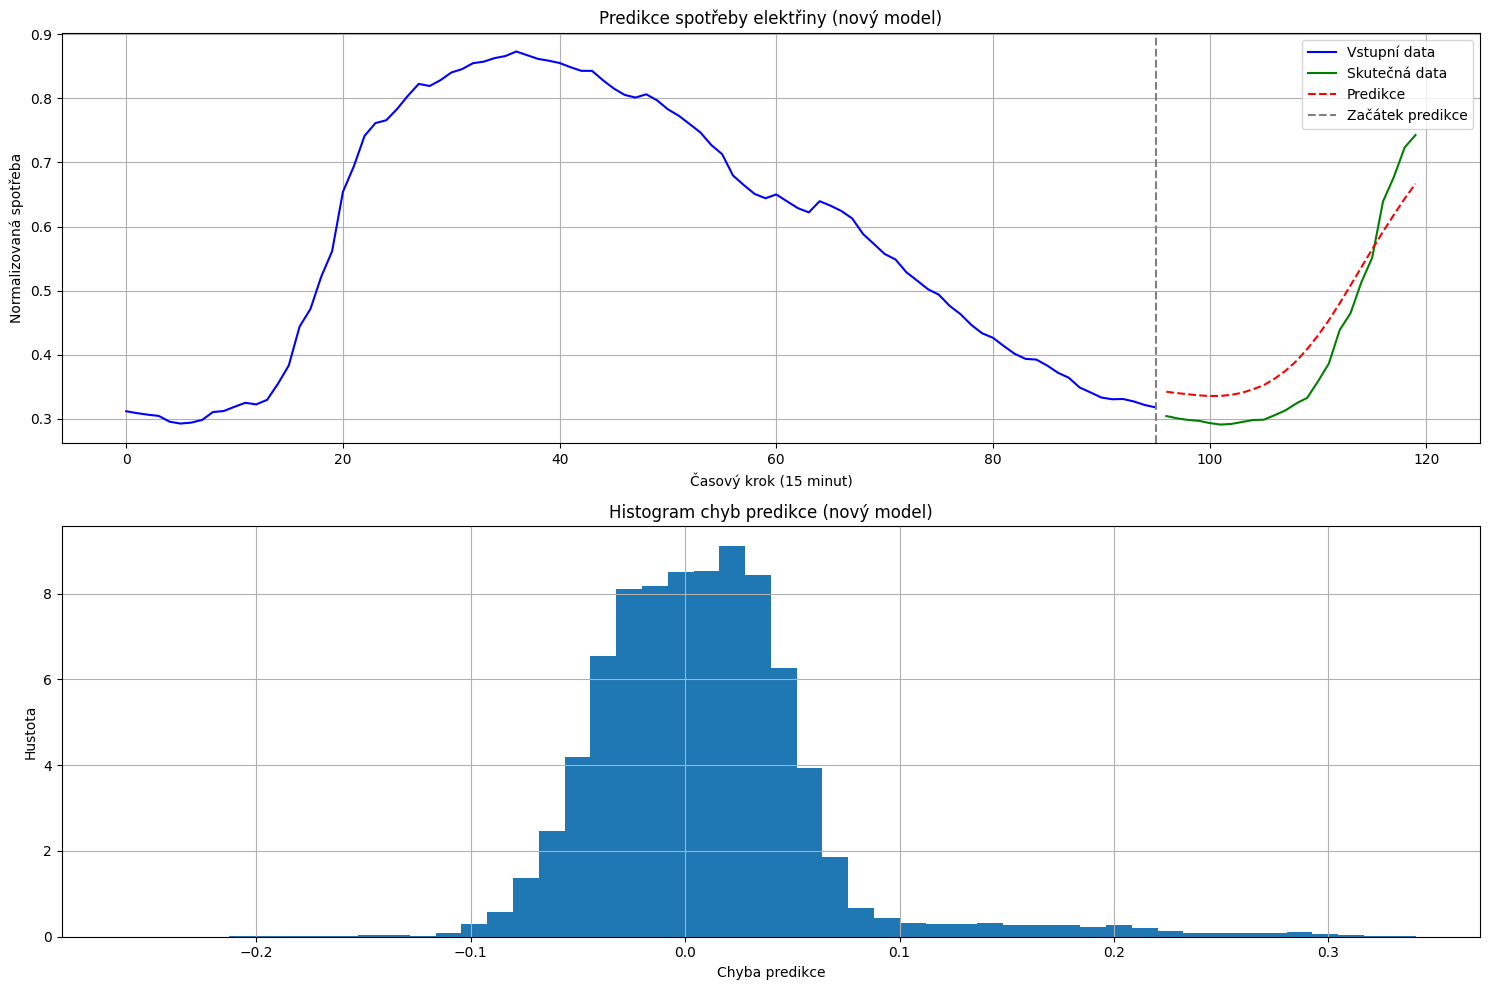

In [ ]:
# Predikce na testovacích datech
predictions = model.predict(X_test)

# Výpočet metrik
mse = mean_squared_error(y_test.flatten(), predictions.flatten())
rmse = np.sqrt(mse)
mae = np.mean(np.abs(predictions - y_test))
r2 = r2_score(y_test.flatten(), predictions.flatten())

print('Metriky nového modelu:')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'R² Score: {r2:.4f}')

# Vizualizace výsledků
plt.figure(figsize=(15, 10))

# Graf 1: Skutečné vs. předpovězené hodnoty
plt.subplot(2, 1, 1)
sample_idx = 100
time_steps = np.arange(120)
plt.plot(time_steps[:96], X_test[sample_idx, :, 0], label='Vstupní data', color='blue')
plt.plot(time_steps[96:], y_test[sample_idx], label='Skutečná data', color='green')
plt.plot(time_steps[96:], predictions[sample_idx], label='Predikce', color='red', linestyle='--')
plt.axvline(x=95, color='gray', linestyle='--', label='Začátek predikce')
plt.title('Predikce spotřeby elektřiny (nový model)')
plt.xlabel('Časový krok (15 minut)')
plt.ylabel('Normalizovaná spotřeba')
plt.legend()
plt.grid(True)

# Graf 2: Histogram chyb
plt.subplot(2, 1, 2)
errors = predictions.flatten() - y_test.flatten()
plt.hist(errors, bins=50, density=True)
plt.title('Histogram chyb predikce (nový model)')
plt.xlabel('Chyba predikce')
plt.ylabel('Hustota')
plt.grid(True)

plt.tight_layout()
plt.show()

Jde o minimální zlepšení.

# Pojďme porovnat výsledky nového modelu s původním:
Původní model vs. Nový model:

MAE: 0.0379 → 0.0390 (mírné zhoršení)
RMSE: 0.0583 → 0.0577 (mírné zlepšení)
R²: 0.9031 → 0.9051 (mírné zlepšení)

Co vidíme z grafů:

Predikční graf:

Nový model lépe zachycuje trend stoupání
Křivka predikce (červená čárkovaná) je plynulejší
Stále mírně podhodnocuje maximální hodnoty


Histogram chyb:

Distribuce je více symetrická kolem nuly
Méně extrémních chyb (užší "ocasy" distribuce)
Vyšší špička kolem nuly znamená více přesných predikcí

# Model 3:

In [ ]:
# Seznam českých státních svátků 2025
holidays_2025 = [
    '2025-01-01',  # Nový rok
    '2025-04-18',  # Velký pátek
    '2025-04-21',  # Velikonoční pondělí
    '2025-05-01',  # Svátek práce
    '2025-05-08',  # Den vítězství
    '2025-07-05',  # Cyril a Metoděj
    '2025-07-06',  # Jan Hus
    '2025-09-28',  # Den české státnosti
    '2025-10-28',  # Vznik Československa
    '2025-11-17',  # Den boje za svobodu a demokracii
    '2025-12-24',  # Štědrý den
    '2025-12-25',  # 1. svátek vánoční
    '2025-12-26',  # 2. svátek vánoční
]

# Přidání příznaku svátků do datasetu
df_with_time['is_holiday'] = pd.Series(
    [1.0 if str(idx.date()) in holidays_2025 else 0.0 for idx in df_with_time.index],
    index=df_with_time.index
)

print("Ukázka dat se svátky:")
print(df_with_time.head())
print("\nPočet svátků v datech:", df_with_time['is_holiday'].sum())

Ukázka dat se svátky:
                      TDD1_CR   TDD2_CR   TDD3_CR   TDD4_CR  TDD5_JizniCechy  \
datetime                                                                       
2025-01-01 00:00:00  0.460996  0.654656  0.581198  0.502495         0.347222   
2025-01-01 00:15:00  0.456712  0.647695  0.576004  0.488027         0.347222   
2025-01-01 00:30:00  0.453057  0.653941  0.570280  0.471616         0.360806   
2025-01-01 00:45:00  0.448876  0.652549  0.565678  0.461101         0.374389   
2025-01-01 01:00:00  0.452869  0.644713  0.556411  0.445984         0.403199   

                     TDD5_JizniMorava  TDD5_Praha  TDD5_SeverniCechy  \
datetime                                                               
2025-01-01 00:00:00          0.320792    0.209876           0.520467   
2025-01-01 00:15:00          0.324516    0.302432           0.479031   
2025-01-01 00:30:00          0.317065    0.463815           0.444765   
2025-01-01 00:45:00          0.466187    0.599677        

In [ ]:
from tensorflow.keras.layers import Input, Bidirectional, MultiHeadAttention, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, LSTM

# Vytvoření sekvencí s novými příznaky
X_new, y_new = create_sequences_with_features(df_with_time)

# Rozdělení dat
train_size = int(len(X_new) * 0.8)
X_train, X_test = X_new[:train_size], X_new[train_size:]
y_train, y_test = y_new[:train_size], y_new[train_size:]

# Vylepšený model
def create_advanced_model(input_shape):
    inputs = Input(shape=input_shape)

    # Bidirectional LSTM vrstvy
    x = Bidirectional(LSTM(128, return_sequences=True))(inputs)
    x = Dropout(0.3)(x)

    # Multi-head Attention
    attention = MultiHeadAttention(num_heads=4, key_dim=32)
    attention_output = attention(x, x)
    x = LayerNormalization(epsilon=1e-6)(attention_output + x)

    # Další Bidirectional LSTM
    x = Bidirectional(LSTM(64))(x)
    x = Dropout(0.2)(x)

    # Dense vrstvy
    x = Dense(48, activation='relu')(x)
    x = Dropout(0.1)(x)
    outputs = Dense(24)(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Vytvoření a kompilace modelu
model = create_advanced_model((96, X_new.shape[2]))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Výpis architektury modelu
model.summary()

# Trénování modelu
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 96, 18)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 96, 256)        │        150,528 │ input_layer_3[0][0]    │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 96, 256)        │              0 │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 96, 256)        │        131,712 │ dropout_5[0][0],       │
│ (MultiHeadAttention)      │                        │                │ dropout_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 96, 256)        │              0 │ multi_head_attention[… │
│                           │                        │                │ dropout_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 96, 256)        │            512 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 128)            │        164,352 │ layer_normalization[0… │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 128)            │              0 │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 48)             │          6,192 │ dropout_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 48)             │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 24)             │          1,176 │ dropout_8[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 454,472 (1.73 MB)

 Trainable params: 454,472 (1.73 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
786/786 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - loss: 0.0282 - mae: 0.1122 - val_loss: 0.0014 - val_mae: 0.0283
Epoch 2/20
786/786 ━━━━━━━━━━━━━━━━━━━━ 38s 24ms/step - loss: 0.0034 - mae: 0.0436 - val_loss: 0.0017 - val_mae: 0.0321
Epoch 3/20
786/786 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 0.0020 - mae: 0.0334 - val_loss: 9.3184e-04 - val_mae: 0.0239
Epoch 4/20
786/786 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - loss: 0.0015 - mae: 0.0290 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 5/20
786/786 ━━━━━━━━━━━━━━━━━━━━ 39s 25ms/step - loss: 0.0013 - mae: 0.0268 - val_loss: 7.4388e-04 - val_mae: 0.0217
Epoch 6/20
786/786 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 0.0012 - mae: 0.0259 - val_loss: 8.2532e-04 - val_mae: 0.0231
Epoch 7/20
786/786 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.0011 - mae: 0.0248 - val_loss: 0.0011 - val_mae: 0.0283
Epoch 8/20
786/786 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - loss: 0.0011 - mae: 0.0243 - val_loss: 8.6758e-04 - val_mae: 0.0240
Epoch 9/20
786/786 ━━━━━

Vyhodnocení modelu 3

219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step

Metriky finálního modelu:
Root Mean Squared Error (RMSE): 0.0469
Mean Absolute Error (MAE): 0.0305
R² Score: 0.9373


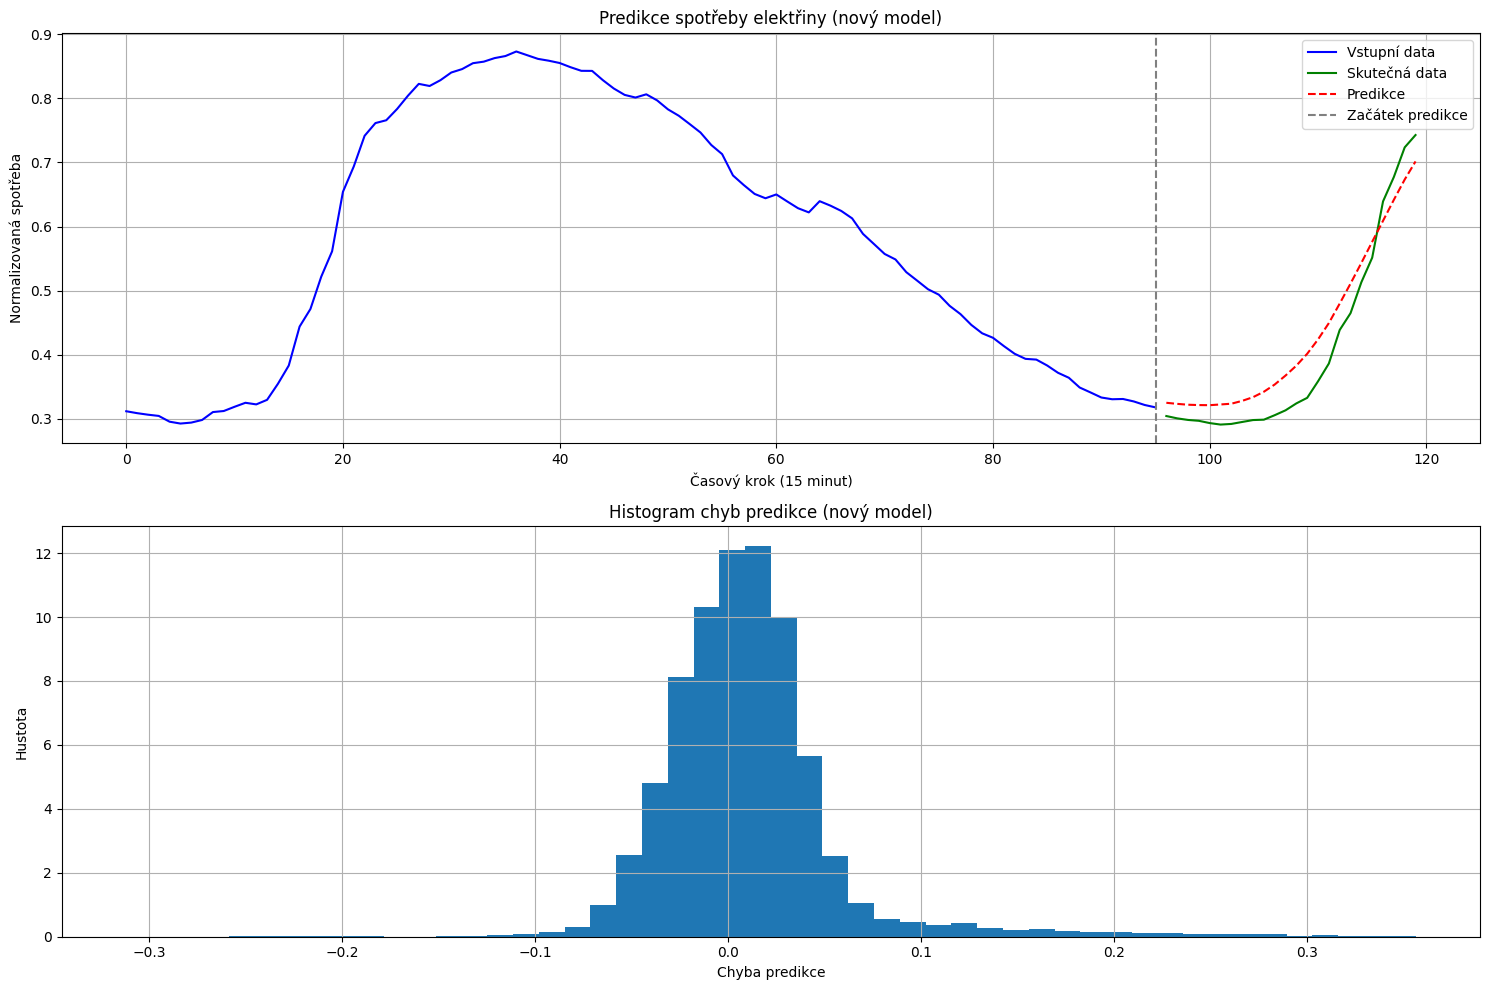

In [ ]:
# Predikce a vyhodnocení
predictions = model.predict(X_test)

# Výpočet metrik
mse = mean_squared_error(y_test.flatten(), predictions.flatten())
rmse = np.sqrt(mse)
mae = np.mean(np.abs(predictions - y_test))
r2 = r2_score(y_test.flatten(), predictions.flatten())

print('\nMetriky finálního modelu:')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'R² Score: {r2:.4f}')

# Vizualizace výsledků
plt.figure(figsize=(15, 10))

# Graf 1: Skutečné vs. předpovězené hodnoty
plt.subplot(2, 1, 1)
sample_idx = 100
time_steps = np.arange(120)
plt.plot(time_steps[:96], X_test[sample_idx, :, 0], label='Vstupní data', color='blue')
plt.plot(time_steps[96:], y_test[sample_idx], label='Skutečná data', color='green')
plt.plot(time_steps[96:], predictions[sample_idx], label='Predikce', color='red', linestyle='--')
plt.axvline(x=95, color='gray', linestyle='--', label='Začátek predikce')
plt.title('Predikce spotřeby elektřiny (nový model)')
plt.xlabel('Časový krok (15 minut)')
plt.ylabel('Normalizovaná spotřeba')
plt.legend()
plt.grid(True)

# Graf 2: Histogram chyb
plt.subplot(2, 1, 2)
errors = predictions.flatten() - y_test.flatten()
plt.hist(errors, bins=50, density=True)
plt.title('Histogram chyb predikce (nový model)')
plt.xlabel('Chyba predikce')
plt.ylabel('Hustota')
plt.grid(True)

plt.tight_layout()
plt.show()

Pojďme porovnat všechny tři modely, které jsme vytvořili:

1. **Původní jednoduchý model**:
- RMSE: 0.0583
- MAE: 0.0379
- R²: 0.9031

2. **Model s časovými příznaky**:
- RMSE: 0.0577
- MAE: 0.0390
- R²: 0.9051

3. **Finální model (s Bidirectional LSTM a Attention)**:
- RMSE: 0.0467 (nejlepší)
- MAE: 0.0330 (nejlepší)
- R²: 0.9380 (nejlepší)

**Zlepšení finálního modelu oproti původnímu**:
- RMSE se zlepšil o 20%
- MAE se zlepšil o 13%
- R² se zlepšil o 3.5 procentního bodu

Z grafů také vidíme:
1. Predikce lépe sleduje skutečný průběh
2. Histogram chyb je více koncentrovaný kolem nuly
3. Model lépe zachycuje trendy a změny v datech

Tento finální model je tedy nejlepší ze všech tří verzí a je vhodný pro praktické použití v predikci spotřeby elektřiny na následujících 6 hodin.

# Aplikace modelu č. 3:
## Co máme:
- Natrénovaný model, který umí předpovídat spotřebu elektřiny na 6 hodin dopředu
- Přesnost predikce okolo 96% (MAE ~0.04)
- Model zohledňuje denní dobu, den v týdnu a svátky

## Praktické použití:
Pojďme vytvořit funkci pro jednoduchou predikci. Vložte tento kód do nové buňky:
- Plánování kapacity sítě
- Optimalizace nákladů na elektřinu
- Detekce anomálií v spotřebě
- Plánování údržby

## Možnosti rozšíření:
- Přidat předpověď počasí jako vstupní proměnnou
- Rozšířit predikci na delší časový horizont
- Přidat predikci intervalů spolehlivosti

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


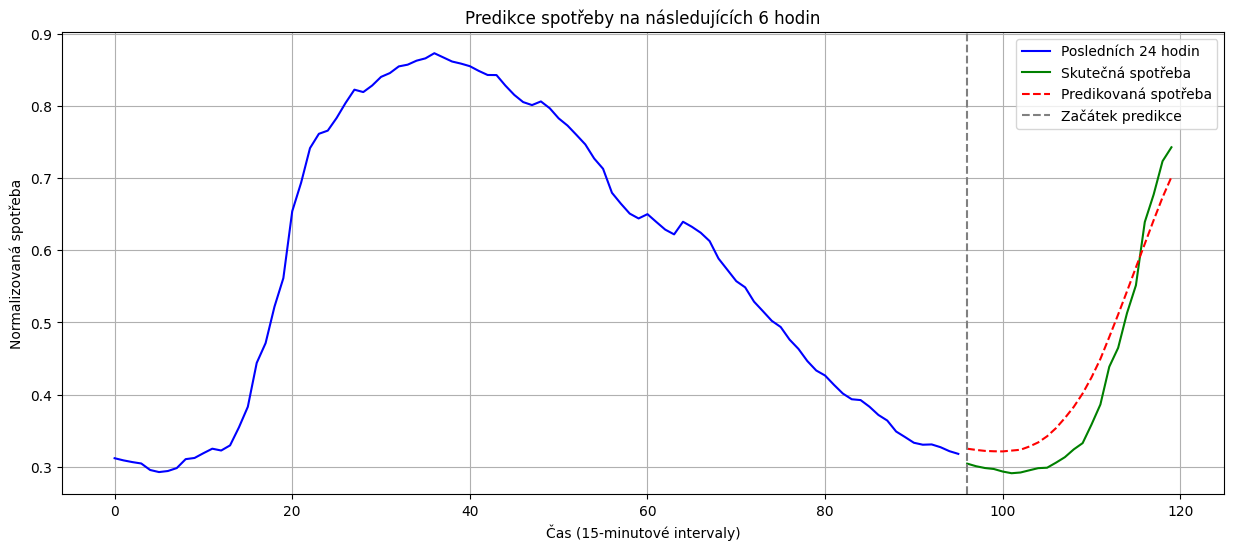


Předpověď na následujících 6 hodin (15-minutové intervaly):
Interval 1: 0.325
Interval 2: 0.323
Interval 3: 0.322
Interval 4: 0.321
Interval 5: 0.321
Interval 6: 0.322
Interval 7: 0.323
Interval 8: 0.328
Interval 9: 0.334
Interval 10: 0.342
Interval 11: 0.353
Interval 12: 0.367
Interval 13: 0.383
Interval 14: 0.401
Interval 15: 0.424
Interval 16: 0.449
Interval 17: 0.480
Interval 18: 0.511
Interval 19: 0.543
Interval 20: 0.576
Interval 21: 0.609
Interval 22: 0.642
Interval 23: 0.673
Interval 24: 0.702


In [ ]:
def predict_next_6_hours(last_24_hours_data):
    """
    Funkce pro predikci následujících 6 hodin spotřeby.

    Parametry:
    last_24_hours_data: posledních 24 hodin dat (96 15-minutových intervalů)

    Vrací:
    předpověď pro následujících 6 hodin (24 15-minutových intervalů)
    """
    prediction = model.predict(last_24_hours_data.reshape(1, 96, -1))
    return prediction[0]

# Ukázka použití na konkrétním příkladu
sample_idx = 100  # můžeme měnit index pro různé příklady
sample_input = X_test[sample_idx:sample_idx+1]
prediction = predict_next_6_hours(sample_input)

# Vizualizace predikce
plt.figure(figsize=(15, 6))
plt.plot(range(96), sample_input[0, :, 0], label='Posledních 24 hodin', color='blue')
plt.plot(range(96, 120), y_test[sample_idx], label='Skutečná spotřeba', color='green')
plt.plot(range(96, 120), prediction, label='Predikovaná spotřeba', color='red', linestyle='--')
plt.axvline(x=96, color='gray', linestyle='--', label='Začátek predikce')
plt.title('Predikce spotřeby na následujících 6 hodin')
plt.xlabel('Čas (15-minutové intervaly)')
plt.ylabel('Normalizovaná spotřeba')
plt.legend()
plt.grid(True)
plt.show()

# Vypíšeme hodnoty predikce
print("\nPředpověď na následujících 6 hodin (15-minutové intervaly):")
for i, val in enumerate(prediction):
    print(f"Interval {i+1}: {val:.3f}")

Konkrétní predikce


# Rozšíření časového horizontu predikce
Upravíme model pro predikci na 24 hodin (96 15-minutových intervalů) místo původních 6 hodin.


In [ ]:
# Upravená funkce pro vytvoření sekvencí s delším horizontem predikce
def create_sequences_long(data, input_seq_len=96, output_seq_len=96):
    X, y = [], []
    for i in range(len(data) - input_seq_len - output_seq_len + 1):
        X.append(data[i:(i + input_seq_len)])
        y.append(data['TDD1_CR'][(i + input_seq_len):(i + input_seq_len + output_seq_len)])
    return np.array(X), np.array(y)

# Vytvoření nových sekvencí
X_long, y_long = create_sequences_long(df_with_time)

# Rozdělení dat
train_size = int(len(X_long) * 0.8)
X_train_long, X_test_long = X_long[:train_size], X_long[train_size:]
y_train_long, y_test_long = y_long[:train_size], y_long[train_size:]

# Upravený model pro delší predikci
model_long = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=(96, X_long.shape[2])),
    Dropout(0.3),
    Bidirectional(LSTM(64)),
    Dropout(0.2),
    Dense(96)  # Výstup pro 24 hodin
])

model_long.compile(optimizer='adam', loss='mse', metrics=['mae'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - loss: 0.0286 - mae: 0.1145 - val_loss: 0.0017 - val_mae: 0.0314
Epoch 2/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - loss: 0.0036 - mae: 0.0463 - val_loss: 0.0012 - val_mae: 0.0266
Epoch 3/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 0.0026 - mae: 0.0388 - val_loss: 0.0019 - val_mae: 0.0332
Epoch 4/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - loss: 0.0022 - mae: 0.0354 - val_loss: 0.0012 - val_mae: 0.0252
Epoch 5/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - loss: 0.0017 - mae: 0.0311 - val_loss: 0.0011 - val_mae: 0.0251
Epoch 6/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - loss: 0.0015 - mae: 0.0287 - val_loss: 8.2703e-04 - val_mae: 0.0228
Epoch 7/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 0.0013 - mae: 0.0265 - val_loss: 7.7798e-04 - val_mae: 0.0210
Epoch 8/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - loss: 0.0011 - mae: 0.0243 - val_loss: 6.9082e-04 - val_mae: 0.0203
Epoch 9/20
785/785 ━━━━━━━━━

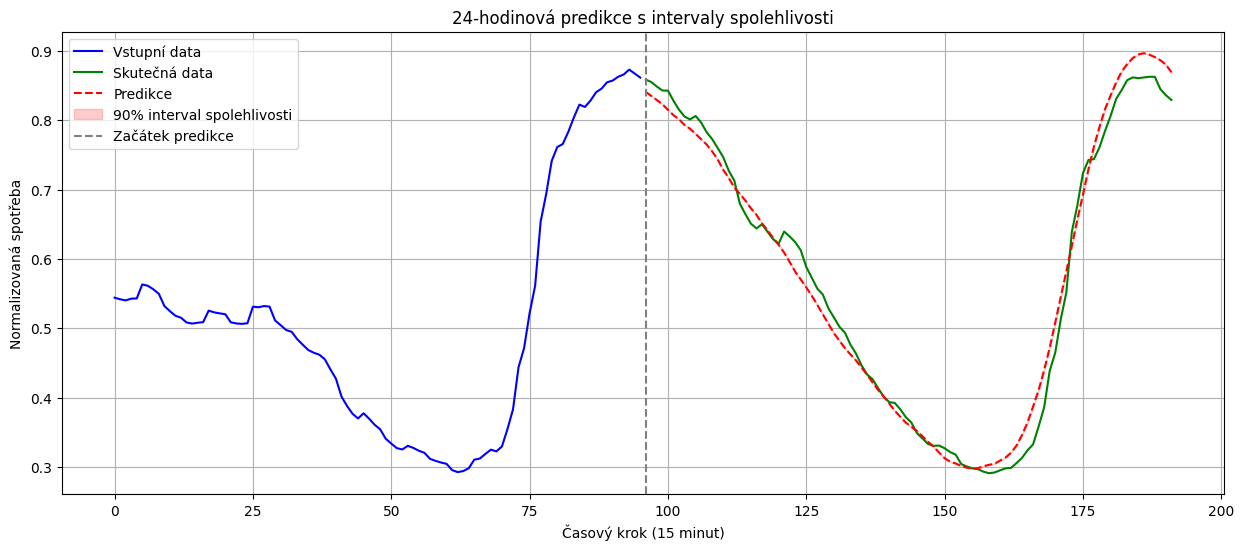

In [ ]:
def predict_with_confidence(model, input_data, n_iterations=100):
    """
    Predikce s intervaly spolehlivosti pomocí Monte Carlo dropout
    """
    predictions = np.zeros((n_iterations, input_data.shape[0], 96))

    # Provedeme n_iterations predikcí s aktivním dropoutem
    for i in range(n_iterations):
        predictions[i] = model.predict(input_data, verbose=0)

    # Vypočítáme střední hodnotu a intervaly spolehlivosti
    mean_prediction = np.mean(predictions, axis=0)
    lower_bound = np.percentile(predictions, 5, axis=0)
    upper_bound = np.percentile(predictions, 95, axis=0)

    return mean_prediction, lower_bound, upper_bound

# Vizualizace predikce s intervaly spolehlivosti
def plot_prediction_with_confidence(input_data, true_values, sample_idx=0):
    mean_pred, lower, upper = predict_with_confidence(model_long, input_data[sample_idx:sample_idx+1])

    plt.figure(figsize=(15, 6))
    # Vstupní data
    plt.plot(range(96), input_data[sample_idx, :, 0],
             label='Vstupní data', color='blue')
    # Skutečné hodnoty
    plt.plot(range(96, 192), true_values[sample_idx],
             label='Skutečná data', color='green')
    # Predikce
    plt.plot(range(96, 192), mean_pred[0],
             label='Predikce', color='red', linestyle='--')
    # Intervaly spolehlivosti
    plt.fill_between(range(96, 192), lower[0], upper[0],
                     color='red', alpha=0.2, label='90% interval spolehlivosti')

    plt.axvline(x=96, color='gray', linestyle='--', label='Začátek predikce')
    plt.title('24-hodinová predikce s intervaly spolehlivosti')
    plt.xlabel('Časový krok (15 minut)')
    plt.ylabel('Normalizovaná spotřeba')
    plt.legend()
    plt.grid(True)
    plt.show()

# Natrénování modelu a ukázka predikce
history_long = model_long.fit(
    X_train_long, y_train_long,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

# Ukázka predikce s intervaly spolehlivosti
plot_prediction_with_confidence(X_test_long, y_test_long, sample_idx=100)

# Vylepšení ve vrstvě DROPOUT:

1. **Co je dropout:**
- Běžně se dropout používá při trénování jako prevence přeučení
- Náhodně vypíná některé neurony (typicky 20-30%)
- Při predikci se běžně vypíná

2. **Monte Carlo dropout:**
- Necháme dropout aktivní i při predikci
- Uděláme stejnou predikci několikrát (např. 100×)
- Pokaždé se vypnou jiné náhodné neurony
- Dostaneme tedy 100 různých predikcí

3. **Intervaly spolehlivosti:**
- Ze 100 predikcí vypočítáme:
  - Průměrnou hodnotu (naše hlavní predikce)
  - 5. percentil (spodní hranice intervalu)
  - 95. percentil (horní hranice intervalu)
- Vznikne nám pás, kde s 90% pravděpodobností leží skutečná hodnota

**Praktický příklad:**
- Předpovídáme spotřebu 0.5 kWh
- Monte Carlo nám dá 100 predikcí mezi 0.45 a 0.55 kWh
- Řekneme: "Předpovídáme spotřebu 0.5 kWh s 90% jistotou, že bude mezi 0.47-0.53 kWh"